<a href="https://colab.research.google.com/github/DakshSharma755/model_comparer/blob/main/comparision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 ! pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

!mv kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download heeraldedhia/groceries-dataset

Dataset URL: https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset
License(s): GPL-2.0
  0% 0.00/257k [00:00<?, ?B/s]
100% 257k/257k [00:00<00:00, 567MB/s]


In [4]:
    !unzip /content/groceries-dataset.zip

Archive:  /content/groceries-dataset.zip
  inflating: Groceries_dataset.csv   


In [5]:
import pandas as pd

df = pd.read_csv('/content/Groceries_dataset.csv')
df.head()


,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [6]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Count number of products sold each day
daily_sales = df.groupby('Date').size()
daily_sales = daily_sales.rename('Sales')
daily_sales = daily_sales.asfreq('D').fillna(0)  # Fill missing dates with 0 sales


In [7]:
window = 7
data = pd.DataFrame(daily_sales)
for i in range(1, window + 1):
    data[f'lag_{i}'] = data['Sales'].shift(i)

data.dropna(inplace=True)

from sklearn.model_selection import train_test_split
X = data.drop(columns='Sales')
y = data['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled = scaler.fit_transform(daily_sales.values.reshape(-1, 1))

def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(scaled, window)
split = int(len(X_lstm) * 0.8)

X_train_lstm = X_lstm[:split]
X_test_lstm = X_lstm[split:]
y_train_lstm = y_lstm[:split]
y_test_lstm = y_lstm[split:]

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], window, 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], window, 1))


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

model = Sequential()
model.add(Input(shape=(window, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history_1 = model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=16, verbose=1)
y_pred_lstm = model.predict(X_test_lstm)


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.2042
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0196
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0179
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0196
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0198
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172
Epoch 13/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0164
Epoch 14/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190
Epoch 15/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188
Epoch 16/20
37/37 

In [11]:
y_test_lstm_inv = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)


In [12]:
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("Linear Regression:")
print("MAE:", mae_lr)
print("RMSE:", rmse_lr)

mae_lstm = mean_absolute_error(y_test_lstm_inv, y_pred_lstm_inv)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_inv, y_pred_lstm_inv))

print("\nLSTM:")
print("MAE:", mae_lstm)
print("RMSE:", rmse_lstm)


Linear Regression:
MAE: 11.013155394771
RMSE: 14.171087354412126

LSTM:
MAE: 11.064978079960264
RMSE: 14.3004776380366


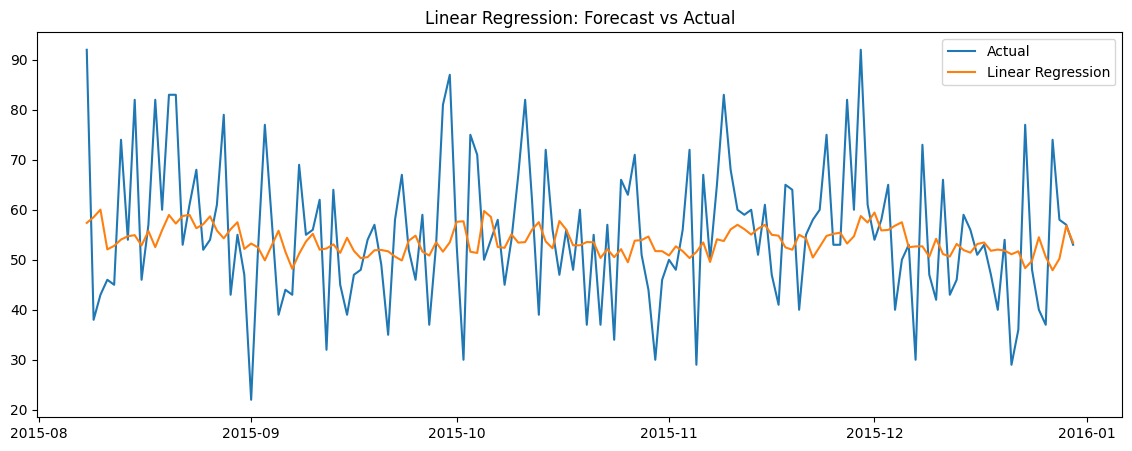

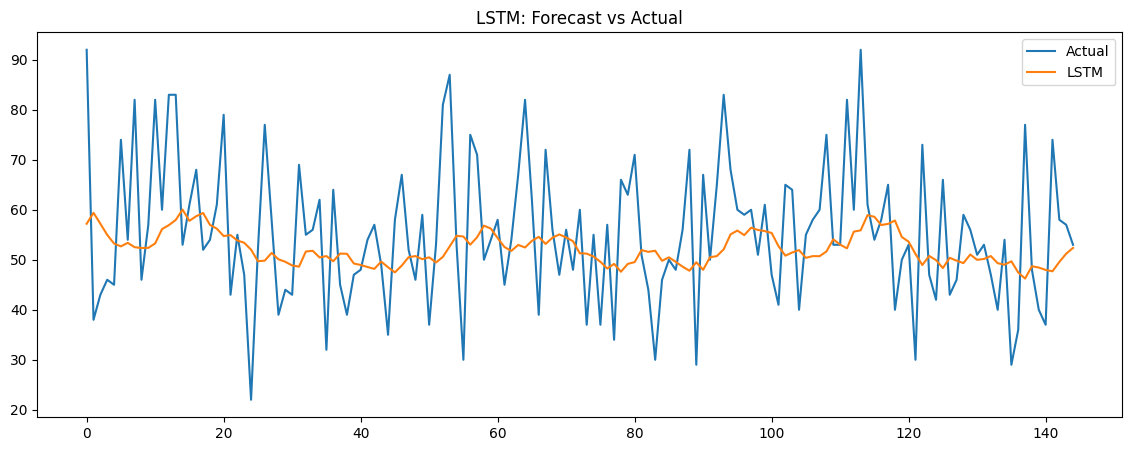

In [13]:
import matplotlib.pyplot as plt

# Linear Regression Plot
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred_lr, label='Linear Regression')
plt.title('Linear Regression: Forecast vs Actual')
plt.legend()
plt.show()

# LSTM Plot
plt.figure(figsize=(14,5))
plt.plot(y_test_lstm_inv, label='Actual')
plt.plot(y_pred_lstm_inv, label='LSTM')
plt.title('LSTM: Forecast vs Actual')
plt.legend()
plt.show()
